In [1]:
import numpy as np
import pandas as pd
import six
import tensorflow as tf
import random
import string
import time
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Flatten, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
import keras

os.environ["CUDA_VISIBLE_DEVICES"]="0";  

%matplotlib inline

Using TensorFlow backend.


In [6]:
# Read data
DATA_PATH = 'data/scraped/names_prices_descriptions.pickle'
df_wines = pd.read_pickle(DATA_PATH)

# Clean pricing data
new_prices = []
for row in df_wines['price']:
    try:
        new_prices.append(row[0])
    except:
        new_prices.append(np.nan)
df_wines['price'] = new_prices
df_wines.dropna(subset=['name', 'price'], inplace=True)
df_wines['price'] = df_wines['price'].astype(str)
df_wines = df_wines[df_wines['price'] != '']
df_wines = df_wines[~df_wines['price'].str.contains(' ')]
df_wines['price'] = df_wines['price'].astype(float)

print(df_wines.shape)
df_wines.head()

(15201, 3)


,name,price,description
0,Hall Napa Valley Cabernet Sauvignon 2013,54.99,"Dark garnet in color, the 2013 HALL Napa Valle..."
1,Rombauer Chardonnay 2017,36.99,Rombauer Vineyards was founded in 1982 by Koer...
2,Antinori Tignanello 2015,124.99,#24
3,Borne of Fire Cabernet Sauvignon 2016,19.99,"Like a phoenix rising from the ashes, we have ..."
4,Torbreck Woodcutters Shiraz 2017,21.99,This wine reflects the up and coming Shiraz vi...


In [13]:
NUM_WORDS = 200

# create/fit tokenizer, convert to sequences and pad for model input
docs = df_wines['name'].astype(str)
t = Tokenizer(num_words=NUM_WORDS)
t.fit_on_texts(docs)
encoded_seq = t.texts_to_sequences(docs)
training_max_length = max([len(s) for s in encoded_seq])

# define vocabulary size (largest integer value)
vocab_size = len(t.word_index) + 1
print(vocab_size)

X = pad_sequences(encoded_seq, maxlen=training_max_length, padding='post')
y = df_wines['price']

# Split out the training/testing datasets
X_train,\
X_test,\
y_train,\
y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print some statistics 
print("Wine Prices: mean=${:.2f} median=${:.2f}".format(df_wines['price'].mean(),df_wines['price'].median()))
print("Vocab size: ", vocab_size)
print("Sample count: ", len(encoded_seq))
print("Length of first sequence: ", len(encoded_seq[0]))
print("Max sequence length: ", training_max_length)
print("Sample: ", encoded_seq[0][:10])
print("X: ",X.shape)
print("y: ",y.shape)

10078
Wine Prices: mean=$73.53 median=$27.99
Vocab size:  10078
Sample count:  15201
Length of first sequence:  5
Max sequence length:  12
Sample:  [60, 21, 7, 4, 10]
X:  (15201, 12)
y:  (15201,)


In [8]:
LOSS_METRIC = 'mean_squared_error'

# Define model
model = Sequential()
model.add(Embedding(vocab_size, NUM_WORDS, input_length=training_max_length))
model.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))
print(model.summary())

#d_model = Sequential()
#d_model.add(Embedding(vocab_size, 250, input_length=max_length))
#d_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#d_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
#d_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
#d_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

checkpoint = ModelCheckpoint('data/models_weights/model_price.h5', 
                             monitor=LOSS_METRIC, 
                             verbose=0, 
                             save_best_only=True, 
                             mode='min')
early_stopping = EarlyStopping(monitor=LOSS_METRIC,
                               patience=10,
                               mode='min')
tboard = keras.callbacks.TensorBoard(log_dir='./Graph',
                                     histogram_freq=0, 
                                     write_graph=True, 
                                     write_images=True)
callbacks_list = [checkpoint,early_stopping,tboard]

# compile network
model.compile(loss=LOSS_METRIC, 
              optimizer='adam',
              metrics=['mse']
              )
# fit network
model.fit(X_train, 
          y_train, 
          epochs=500, 
          callbacks=callbacks_list,
          verbose=2)

# Save weights
model.save('data/models_weights/model_price.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 12, 200)           2015600   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 16)             25616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 16)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 2,044,617
Trainable params: 2,044,617
Non-trainable params: 0
_________________________________________________________________


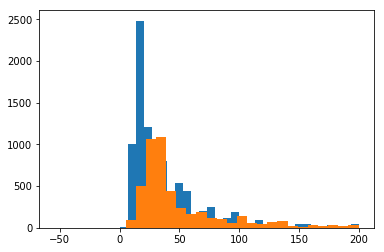

In [47]:
y_model = model.predict(X_test)
y_model = pd.Series([item[0] for item in y_model])
y_model_residuals = y_model - y_test

plt.hist(y_train[y_train < 200], bins=30)
plt.hist(y_model[y_model < 200], bins=30)
plt.show()


In [49]:
# Sample some predicted wines and prices
predictions = model.predict(X_test)
for i in range(1,4):
    print(t.sequences_to_texts(X_test)[i])
    print(predictions[i])
    print('\n')

cava reserva rose 2016
[19.959055]


brunello di montalcino 2013
[83.74307]


vineyard zinfandel 2014
[35.45346]




## Predict prices on fake wines

In [55]:
# Read in fake wine names and descriptions
df_fake_wines = pd.read_csv('data/fake/DESC_v1_2.csv',
                            sep='|',
                            low_memory=False)
df_fake_wines = pd.read_excel('data/fake/names_descriptions.xlsx')

# Run the encodings as was done with training data
encoded_seq = t.texts_to_sequences(df_fake_wines['description'])
max_length = max([len(s) for s in encoded_seq])
fake_X = pad_sequences(encoded_seq, maxlen=training_max_length, padding='post')

print("Sample count: ", len(encoded_seq))
print("Length of first sequence: ", len(encoded_seq[0]))
print("Sample: ", encoded_seq[0][:10])

assert X_train.shape[1] == fake_X.shape[1]
fake_predictions = model.predict(fake_X)

# Save to DF and CSV
df_fake_wines['price'] = fake_predictions.astype(int)
df_fake_wines['price'] = abs(df_fake_wines['price'])
df_fake_wines.to_excel('data/fake/fake_names_descs_prices.xlsx', index=False)

Sample count:  1275
Length of first sequence:  10
Sample:  [50, 86, 39, 122, 7, 4, 39, 7, 135, 29]


In [56]:
df_fake_wines.head()

,name,description,price
0,Joseph Carr Reveliste Cinsault 2013,"Tart bu! Precision wine is a versatile, Merlo...",22
1,Carol Shelton Roche TBredi 2016,Closes possesses a pure-lie agnio of Californ...,414
2,Finca Bolgheri Pinot Grigio 2018,Pair with a first-good to preserve the fruit...,44
3,Domaine de Cristict Chardonnay 2016,\nThere are a rich wine was born in barrel and...,177
4,Domaine Dujac Fils &amp; Pere Chambolle Rouge ...,\nTenuta IX C Went Co Recre vineyard has arou...,581


### Remove wines with less than 300 length descriptions

In [69]:
descriptions_lengths = [len(row) for row in df_fake_wines['description']]
df_fake_wines_300 = df_fake_wines[pd.Series(descriptions_lengths) > 300]
df_fake_wines_300.to_excel('data/fake/fake_names_descs_prices.xlsx', index=False)
print(df_fake_wines_300.shape)

(999, 3)
